C:\Users\Asus\AppData\Local\Temp\ipykernel_3788\1319664467.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\Asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - loss: 0.0057 - val_loss: 0.0039
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - loss: 6.3987e-04 - val_loss: 0.0028
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - loss: 5.9485e-04 - val_loss: 0.0062
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 6.2152e-04 - val_loss: 0.0022
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - loss: 5.2779e-04 - val_loss: 0.0020
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 5.7945e-04 - val_loss: 0.0023
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - loss: 4.6159e-04 - val_loss: 0.0019
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 4.1905e-04 - val_loss: 0.0016
Epoch 9/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 4.5517e-04 - val_loss: 0.0018
Epoch 10/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 4.7884e-04 - val_loss: 0.0022

Validation Loss Reduction: 58.81%

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━

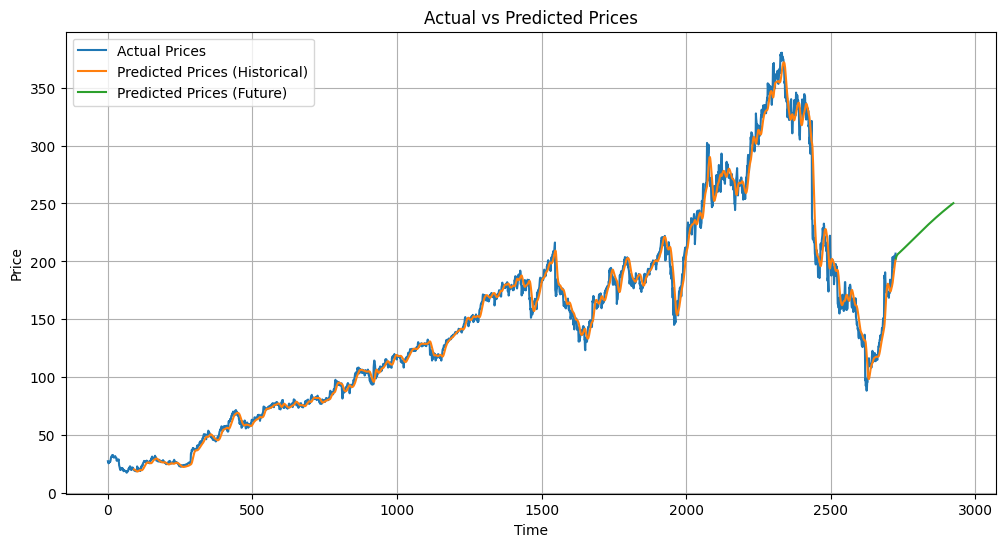

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
Training RMSE: 6.282291140095811
Testing RMSE: 14.506405273720723

Directional Consistency of Future Predictions: 100.00%

Trend of Historical Predictions: Upward
Trend of Future Predictions: Upward
Buy/Sell Call: Buy


In [9]:
# Install necessary library packages
# !pip install tensorflow
# !pip install scikit-learn
# !pip install yfinance
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install streamlit

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Dense

# Function to download stock data
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Function to prepare data for LSTM model
def prepare_data(data, time_steps):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(x), np.array(y)

# Set random seed for reproducibility
np.random.seed(42)

# Download stock data
stock_symbol = "META"
start_date = "2012-06-01"  # Adjust the start date to have more historical data
end_date = "2023-03-31"
stock_data = download_stock_data(stock_symbol, start_date, end_date)

# Prepare closing prices data
closing_prices = stock_data['Close'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)

# Prepare data with time steps
time_steps = 90
x, y = prepare_data(closing_prices_scaled, time_steps)

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(len(x) * split_ratio)
x_train, x_test = x[:split_index], x[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='nadam', loss='mean_squared_error')


from tensorflow.keras.callbacks import EarlyStopping

# Train the model
# Increase epochs for better learning # optimal batch size = 32, 64
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stop])

# Calculate validation loss reduction %
initial_val_loss = history.history['val_loss'][0]
min_val_loss = min(history.history['val_loss'])
val_loss_reduction_pct = ((initial_val_loss - min_val_loss) / initial_val_loss) * 100

print(f"\nValidation Loss Reduction: {val_loss_reduction_pct:.2f}%\n")

# Function to predict future prices
def predict_future_prices(model, last_data, future_days, scaler):
    future_predictions = []
    current_input = last_data.copy()

    for _ in range(future_days):
        predicted_price_scaled = model.predict(current_input)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)
        future_predictions.append(predicted_price[0][0])

        # Update current_input with the latest prediction
        current_input = np.append(current_input[:, 1:, :], predicted_price_scaled.reshape(1, 1, 1), axis=1)

    return future_predictions

# Number of days to predict into the future
future_days = 200

# Prepare the last data for prediction
last_data = closing_prices_scaled[-time_steps:]
last_data = last_data.reshape(1, time_steps, 1)

# Get future price predictions
future_predictions = predict_future_prices(model, last_data, future_days, scaler)

# Predict prices for the historical data
historical_predictions = model.predict(x)

# Inverse transform the historical predictions to original scale
historical_predictions = scaler.inverse_transform(historical_predictions).flatten()

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot actual prices
plt.plot(np.arange(len(closing_prices)), closing_prices, label='Actual Prices')

# Plot predicted prices for historical data
plt.plot(np.arange(time_steps, len(closing_prices)), historical_predictions, label='Predicted Prices (Historical)')

# Plot future predicted prices
plt.plot(np.arange(len(closing_prices), len(closing_prices) + future_days), future_predictions, label='Predicted Prices (Future)')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()




# Import the necessary function
from sklearn.metrics import mean_squared_error

# Predict on training and testing data
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# Inverse transform the predictions
y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_test_pred_inv = scaler.inverse_transform(y_test_pred)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE for training and testing data
train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")


# Function to calculate directional consistency %
def calculate_directional_consistency(prices):
    if len(prices) < 2:
        return 0
    consistent_days = 0
    for i in range(1, len(prices)):
        # Check if price increased or decreased compared to previous day
        # Count as consistent if direction (up or down) is maintained from previous step
        if (prices[i] - prices[i-1]) * (prices[i-1] - prices[i-2]) > 0 if i > 1 else True:
            consistent_days += 1
    consistency_pct = (consistent_days / (len(prices) - 1)) * 100
    return consistency_pct

# Calculate directional consistency on future predictions
directional_consistency = calculate_directional_consistency(future_predictions)
print(f"\nDirectional Consistency of Future Predictions: {directional_consistency:.2f}%\n")


# Determine the trend of predicted prices
def determine_trend(prices):
    trend = "Unknown"
    if len(prices) >= 2:
        if prices[-1] > prices[-2]:
            trend = "Upward"
        elif prices[-1] < prices[-2]:
            trend = "Downward"
        else:
            trend = "Stable"
    return trend

# Analyze the trend of historical predictions
historical_trend = determine_trend(historical_predictions)

# Analyze the trend of future predictions
future_trend = determine_trend(future_predictions)

# Print the trends
print(f"Trend of Historical Predictions: {historical_trend}")
print(f"Trend of Future Predictions: {future_trend}")

# Generate buy/sell call based on the trend analysis
def generate_buy_sell_call(historical_trend, future_trend):
    if historical_trend == "Upward" and future_trend == "Upward":
        return "Buy"
    elif historical_trend == "Downward" and future_trend == "Downward":
        return "Sell"
    else:
        return "Hold"

# Generate the buy/sell call
buy_sell_call = generate_buy_sell_call(historical_trend, future_trend)
print(f"Buy/Sell Call: {buy_sell_call}")
